# $Import$ $Packages$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tnrange, tqdm_notebook
import itertools

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso 
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

from xgboost import XGBRegressor

# $Understanding$ $Data$

In [2]:
df = pd.read_csv('./train.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

## `Item_Weight` and `Outlet_Size` are having null values.

In [4]:
# Cleaning Item_Weights column

In [5]:
null_df = df[df['Item_Weight'].isnull()]
null_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362


In [6]:
# list with unique Item Identifier Values
identifier_list = list(df['Item_Identifier'].unique())

In [7]:
# Made a dictionary and then storing the mean of the values for each unique identifier from the data.
temp = df['Item_Identifier'].nunique()
identifier_dict = {}

for i in identifier_list:
    identifier_dict[i] = round(df[df['Item_Identifier'] == i]['Item_Weight'].mean(),2)

In [8]:
# Function to replace the null value with the mean from dictionary
def replace_weight(row):
    row['Item_Weight'] = identifier_dict[row['Item_Identifier']]
    return row

In [9]:
# Calling the function to replace the null values
tmp_df = null_df.apply(replace_weight, axis = 1)

In [10]:
# Dropping rows where 'Item_Weight' is a null value
df.dropna(subset = ["Item_Weight"], axis = 0, inplace = True)

In [11]:
# Concating the non-value datas together.
data = pd.concat([df, tmp_df])

In [12]:
data.shape

(8523, 12)

In [13]:
# The Item_weight null values are cleaned!
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [14]:
# Cleaning Outlet Size column

In [15]:
data['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [16]:
data[data['Outlet_Size'] == 'Small']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
11,FDA03,18.50,Regular,0.045464,Dairy,144.1102,OUT046,1997,Small,Tier 1,Supermarket Type1,2187.1530
13,FDS46,17.60,Regular,0.047257,Snack Foods,119.6782,OUT046,1997,Small,Tier 1,Supermarket Type1,2145.2076
15,FDP49,9.00,Regular,0.069089,Breakfast,56.3614,OUT046,1997,Small,Tier 1,Supermarket Type1,1547.3192
19,FDU02,13.35,Low Fat,0.102492,Dairy,230.5352,OUT035,2004,Small,Tier 2,Supermarket Type1,2748.4224
22,NCB30,14.60,Low Fat,0.025698,Household,196.5084,OUT035,2004,Small,Tier 2,Supermarket Type1,1587.2672
...,...,...,...,...,...,...,...,...,...,...,...,...
8454,NCH54,13.50,Low Fat,0.127234,Household,158.3920,OUT019,1985,Small,Tier 1,Grocery Store,159.7920
8458,FDX20,7.37,Low Fat,0.074518,Fruits and Vegetables,227.3720,OUT019,1985,Small,Tier 1,Grocery Store,452.7440
8469,FDQ45,9.50,Regular,0.019114,Snack Foods,182.1608,OUT019,1985,Small,Tier 1,Grocery Store,367.5216
8480,FDQ58,7.32,Low Fat,0.000000,Snack Foods,154.5340,OUT019,1985,Small,Tier 1,Grocery Store,459.4020


In [17]:
display(data.loc[(data['Outlet_Size'] == 'Small') & (data['Outlet_Type'] == 'Supermarket Type1')])

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
11,FDA03,18.50,Regular,0.045464,Dairy,144.1102,OUT046,1997,Small,Tier 1,Supermarket Type1,2187.1530
13,FDS46,17.60,Regular,0.047257,Snack Foods,119.6782,OUT046,1997,Small,Tier 1,Supermarket Type1,2145.2076
15,FDP49,9.00,Regular,0.069089,Breakfast,56.3614,OUT046,1997,Small,Tier 1,Supermarket Type1,1547.3192
19,FDU02,13.35,Low Fat,0.102492,Dairy,230.5352,OUT035,2004,Small,Tier 2,Supermarket Type1,2748.4224
22,NCB30,14.60,Low Fat,0.025698,Household,196.5084,OUT035,2004,Small,Tier 2,Supermarket Type1,1587.2672
...,...,...,...,...,...,...,...,...,...,...,...,...
8510,FDN58,13.80,Regular,0.056862,Snack Foods,231.5984,OUT035,2004,Small,Tier 2,Supermarket Type1,7182.6504
8513,FDH31,12.00,Regular,0.020407,Meat,99.9042,OUT035,2004,Small,Tier 2,Supermarket Type1,595.2252
8517,FDF53,20.75,reg,0.083607,Frozen Foods,178.8318,OUT046,1997,Small,Tier 1,Supermarket Type1,3608.6360
8520,NCJ29,10.60,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136


### $Key$ $Observations$ $from$ `Outlet_Type` $and$ `Outlet_Size`
    - if Supermarket Type 1 then replace with Small Medium or High(random)

    - if Supermarket Type 2 then replace with Medium

    - if Supermarket Type 3 then replace with Medium

    - if Grocery Store      then replace with Small


In [18]:
null_df2 = data[data['Outlet_Size'].isnull()]

In [19]:
null_df2.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350
25,NCD06,13.000,Low Fat,0.099887,Household,45.9060,OUT017,2007,NaN,Tier 2,Supermarket Type1,838.9080
28,FDE51,5.925,Regular,0.161467,Dairy,45.5086,OUT010,1998,NaN,Tier 3,Grocery Store,178.4344


In [20]:
outlet_type_list = list(df['Outlet_Type'].unique())

In [21]:
outlet_type_list

['Supermarket Type1', 'Supermarket Type2', 'Grocery Store']

In [22]:
outlet_type_dict = {}

for i in outlet_type_list:
    if i == 'Supermarket Type1':
        outlet_type_dict[i] = ['Small', 'Medium', 'High']
    if i == 'Supermarket Type2':
        outlet_type_dict[i] = 'Medium'
    elif i == 'Grocery Store':
        outlet_type_dict[i] = 'Small'

In [23]:
outlet_type_dict

{'Supermarket Type1': ['Small', 'Medium', 'High'],
 'Supermarket Type2': 'Medium',
 'Grocery Store': 'Small'}

In [24]:
def replace_size(row):
    if row['Outlet_Type'] == 'Supermarket Type1':
        x = np.random.choice(outlet_type_dict['Supermarket Type1'])
    else:
        x = outlet_type_dict[row['Outlet_Type']]
    row['Outlet_Size'] = x
    return row

In [25]:
tmp_df2 = null_df2.apply(replace_size, axis = 1)

In [26]:
data.dropna(subset = ["Outlet_Size"], axis = 0, inplace = True)

In [27]:
final_df = pd.concat([data, tmp_df2])

In [28]:
final_df.shape

(8523, 12)

In [29]:
final_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088


In [30]:
final_df.dropna(inplace = True)

In [31]:
final_df['Outlet_Age'] = final_df['Outlet_Establishment_Year'].apply(lambda x: 2022-x)

In [32]:
final_df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,23
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,13
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,23
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,35
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8502,NCH43,8.420,Low Fat,0.070712,Household,216.4192,OUT045,2002,High,Tier 2,Supermarket Type1,3020.0688,20
8508,FDW31,11.350,Regular,0.043246,Fruits and Vegetables,199.4742,OUT045,2002,Small,Tier 2,Supermarket Type1,2587.9646,20
8509,FDG45,8.100,Low Fat,0.214306,Fruits and Vegetables,213.9902,OUT010,1998,Small,Tier 3,Grocery Store,424.7804,24
8514,FDA01,15.000,Regular,0.054489,Canned,57.5904,OUT045,2002,High,Tier 2,Supermarket Type1,468.7232,20


In [33]:
# Dropping unnecessary columns from the data
final_df.drop(['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year'], axis=1, inplace = True)
final_df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,9.300,Low Fat,0.016047,Dairy,249.8092,Medium,Tier 1,Supermarket Type1,3735.1380,23
1,5.920,Regular,0.019278,Soft Drinks,48.2692,Medium,Tier 3,Supermarket Type2,443.4228,13
2,17.500,Low Fat,0.016760,Meat,141.6180,Medium,Tier 1,Supermarket Type1,2097.2700,23
4,8.930,Low Fat,0.000000,Household,53.8614,High,Tier 3,Supermarket Type1,994.7052,35
5,10.395,Regular,0.000000,Baking Goods,51.4008,Medium,Tier 3,Supermarket Type2,556.6088,13


In [34]:
final_df['Outlet_Type'].unique()

array(['Supermarket Type1', 'Supermarket Type2', 'Supermarket Type3',
       'Grocery Store'], dtype=object)

In [35]:
final_df['Item_Fat_Content'] = final_df['Item_Fat_Content'].replace('low fat', 'Low Fat').replace('reg', 'Regular').replace('LF', 'Low Fat')

# $Exploratory$ $Data$ $Analysis$

Text(0.5, 1.0, 'Pie Chart: Outlet Type')

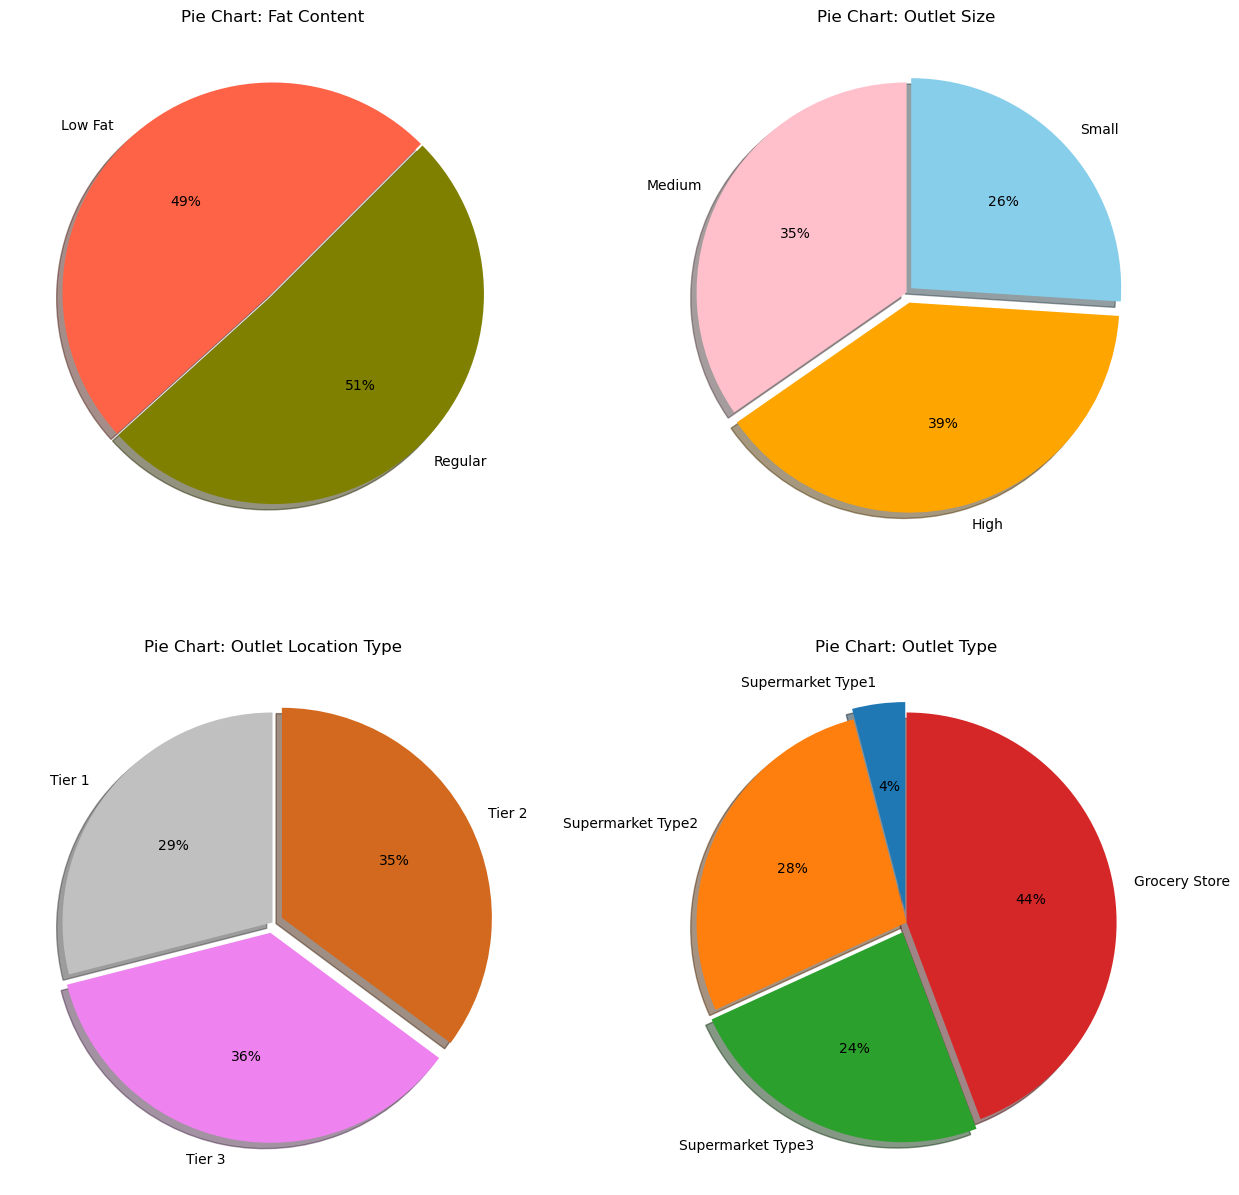

In [36]:
plt.figure(figsize=(15, 15))

explode = (0, 0.01)

plt.subplot(2,2,1)
plt.pie(final_df.groupby(['Item_Fat_Content']).mean().Item_Outlet_Sales,
        labels=['Low Fat', 'Regular'],
        explode = explode,
        autopct='%.0f%%',
        colors = ['Tomato', 'Olive'],
        startangle= 45,
        shadow = True)
plt.title('Pie Chart: Fat Content')

plt.subplot(2,2,2)
plt.pie(final_df.groupby(['Outlet_Size']).mean().Item_Outlet_Sales,
        labels=['Medium', 'High', 'Small'],
        explode = (0, 0.05, 0.03),
        autopct='%.0f%%',
        colors = ['Pink', 'Orange', 'Skyblue'],
        startangle=90,
        shadow = True)
plt.title('Pie Chart: Outlet Size')


plt.subplot(2,2,3)
plt.pie(final_df.groupby(['Outlet_Location_Type']).mean().Item_Outlet_Sales,
        labels=['Tier 1', 'Tier 3', 'Tier 2'],
        explode = (0, 0.05, 0.05),
        autopct='%.0f%%',
        colors = ['silver', 'Violet', 'Chocolate'],
        startangle=90,
        shadow = True)
plt.title('Pie Chart: Outlet Location Type')

plt.subplot(2,2,4)
plt.pie(final_df.groupby(['Outlet_Type']).mean().Item_Outlet_Sales,
        labels=['Supermarket Type1', 'Supermarket Type2', 'Supermarket Type3', 'Grocery Store'],
        explode = (0.05, 0, 0.05, 0),
        autopct='%.0f%%',
        colors = None,
        startangle=90,
        shadow = True)
plt.title('Pie Chart: Outlet Type')

Text(0.5, 1.0, 'Item Type vs Item Outlet Sales')

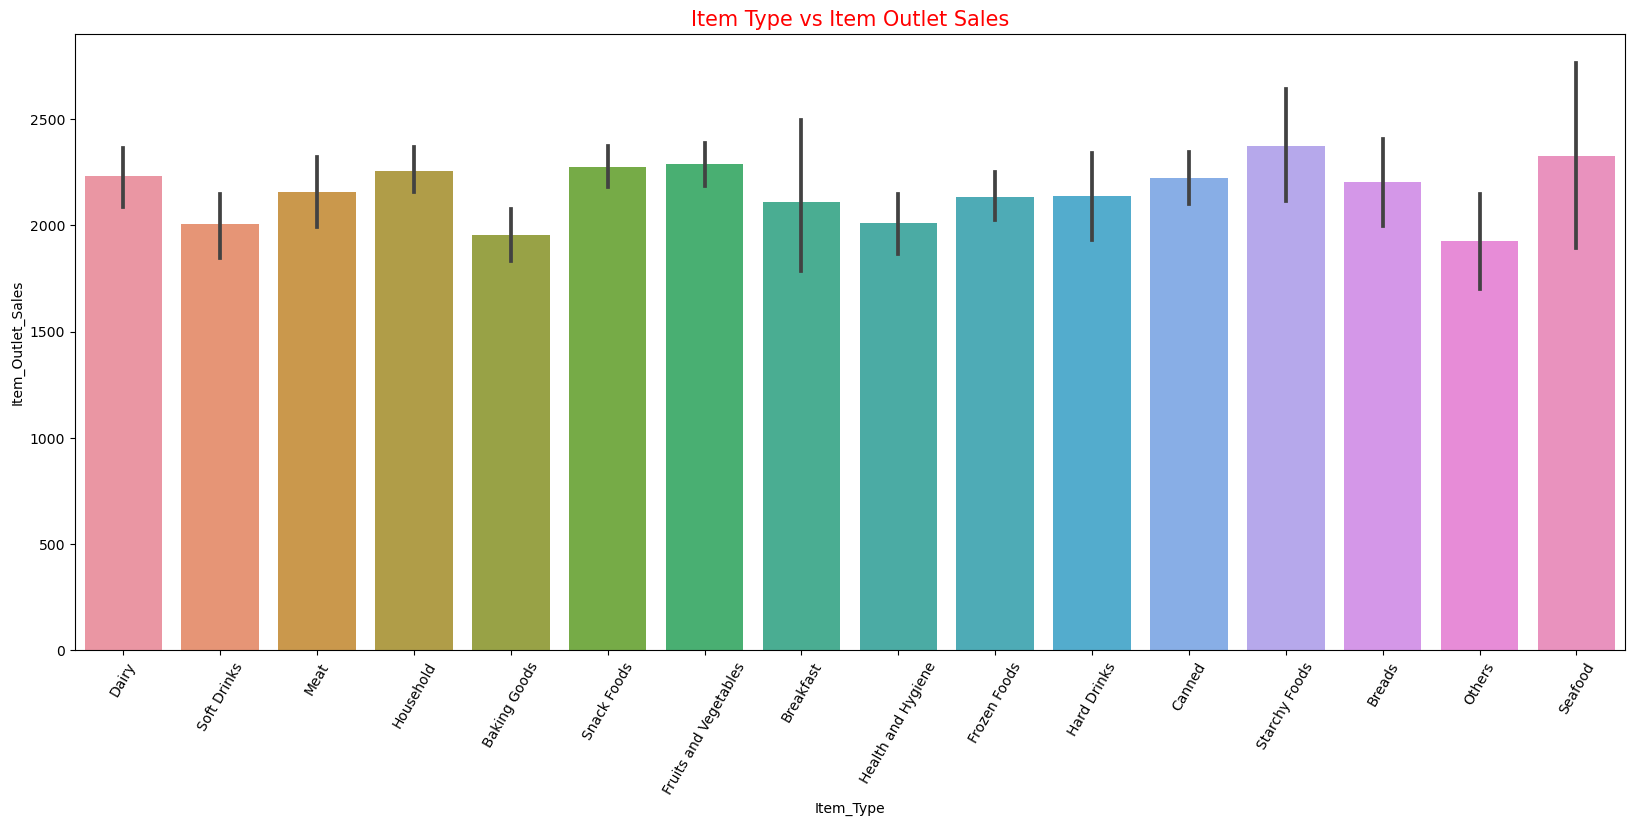

In [37]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation = 60)
sns.barplot(data= final_df, x= 'Item_Type', y='Item_Outlet_Sales')
plt.title(label = 'Item Type vs Item Outlet Sales', fontsize = 15, color = 'red')

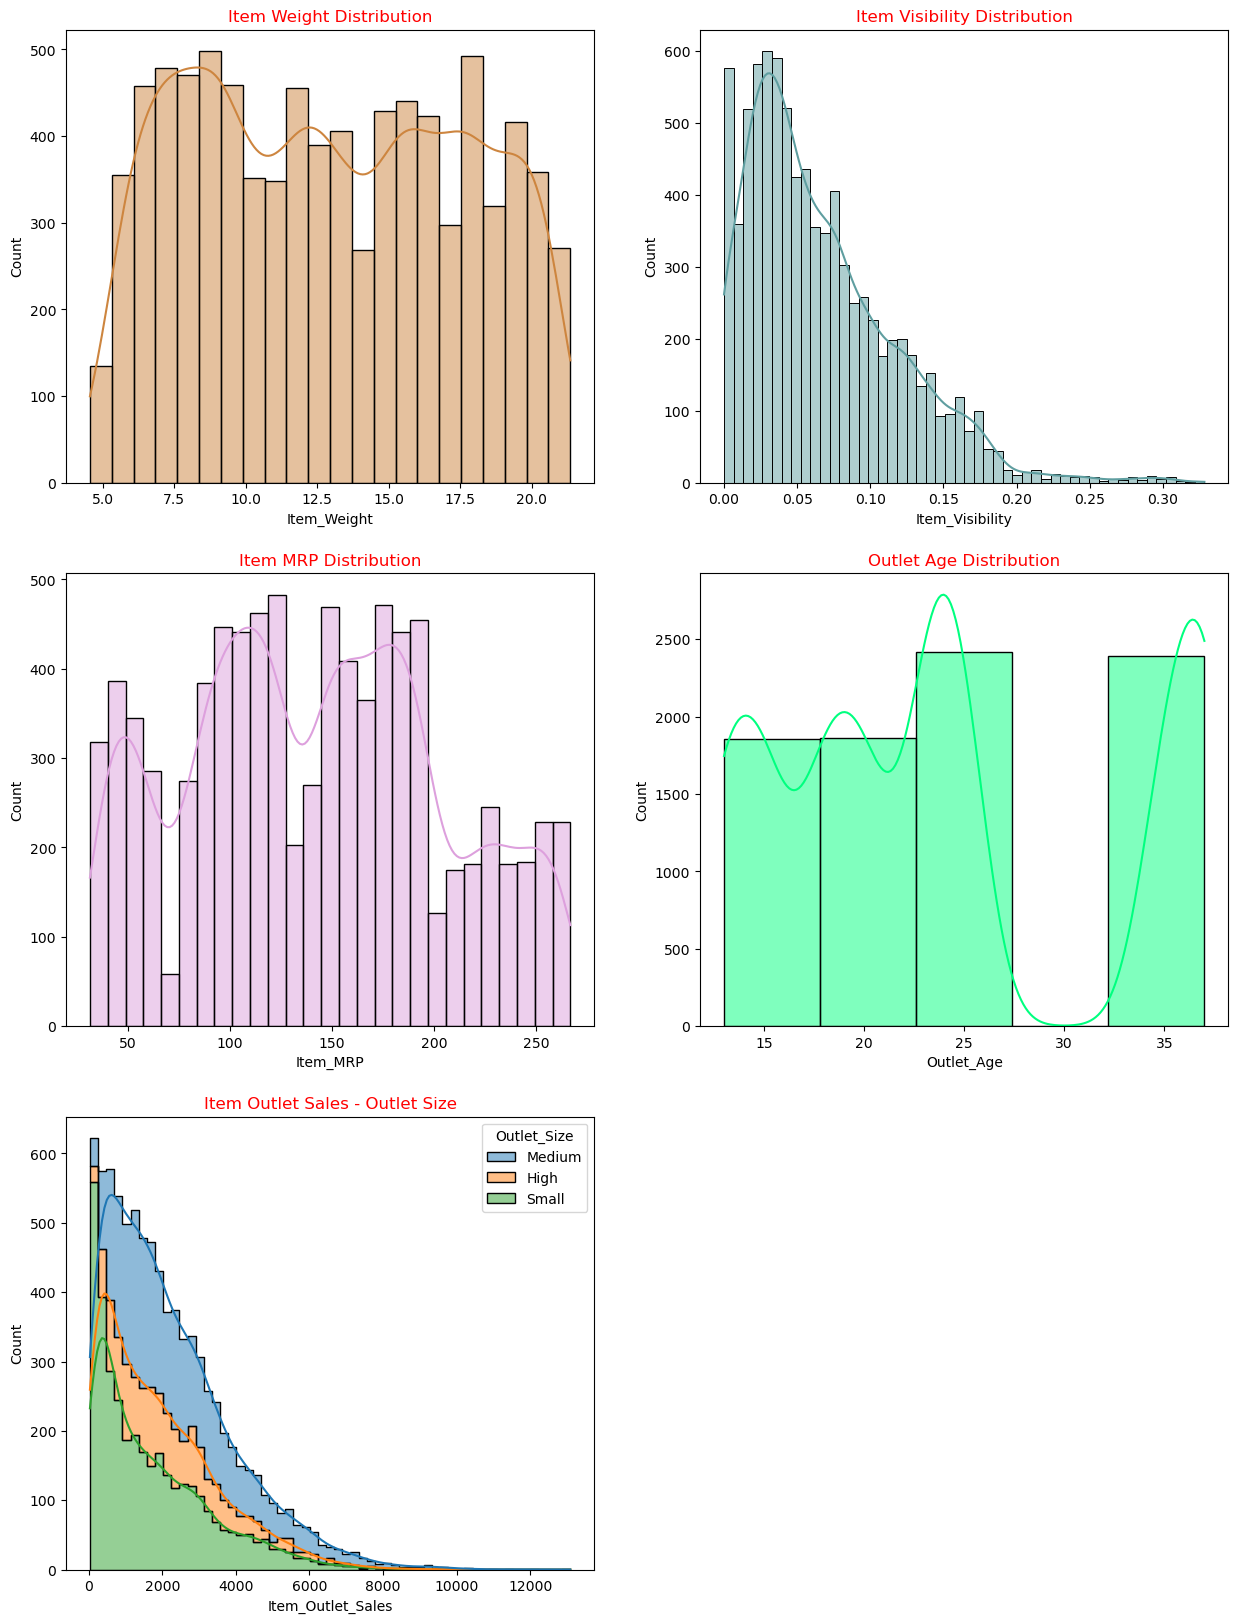

In [38]:
plt.figure(figsize=(15, 20))

plt.subplot(3,2,1)
sns.histplot(data = final_df, x = 'Item_Weight', kde = True, color = 'peru')
plt.title(label = 'Item Weight Distribution', color = 'red')

plt.subplot(3,2,2)
sns.histplot(data = final_df, x = 'Item_Visibility', kde = True, color = 'cadetblue')
plt.title(label = 'Item Visibility Distribution', color = 'red')

plt.subplot(3,2,3)
sns.histplot(data = final_df, x = 'Item_MRP', kde = True, color = 'plum')
plt.title(label = 'Item MRP Distribution', color = 'red')

plt.subplot(3,2,4)
sns.histplot(data = final_df, x = 'Outlet_Age', kde = True, bins= 5, color = 'springgreen')
plt.title(label = 'Outlet Age Distribution', color = 'red')

plt.subplot(3,2,5)
sns.histplot(data = final_df, x = 'Item_Outlet_Sales',hue = 'Outlet_Size', kde = True, multiple = 'stack', element = 'step')
plt.title(label = 'Item Outlet Sales - Outlet Size', color = 'red')

plt.show()

[]

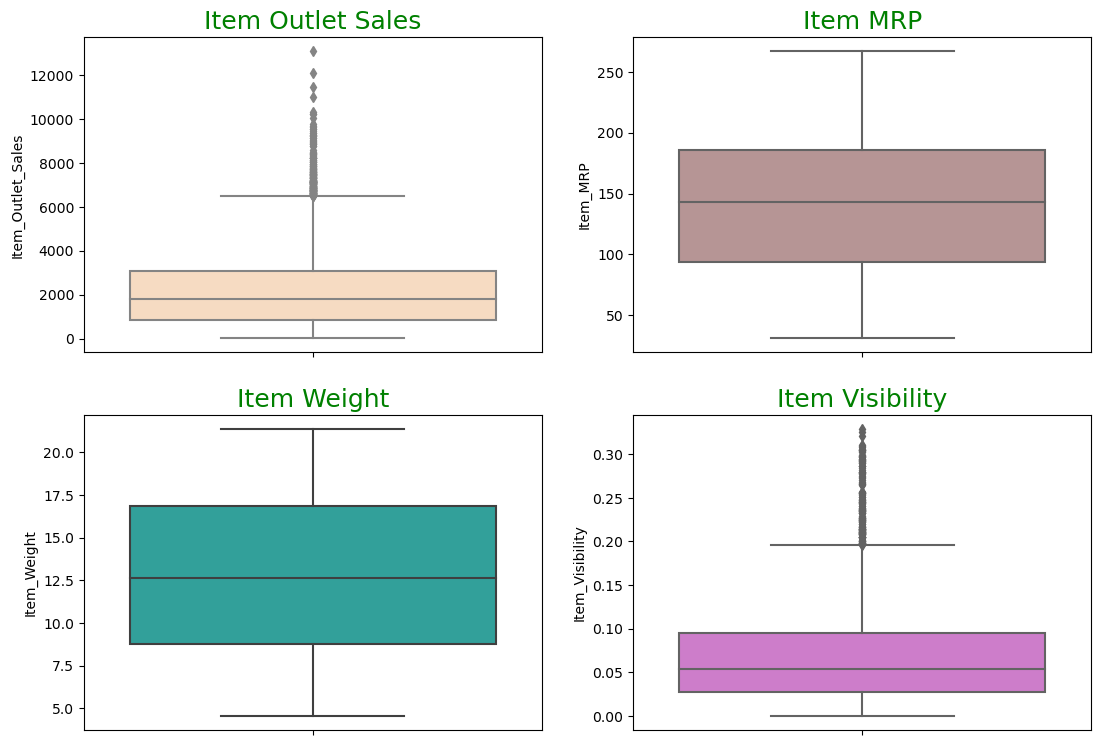

In [39]:
plt.figure(figsize=(13, 9))

plt.subplot(2,2,1)
sns.boxplot(data= final_df, y= 'Item_Outlet_Sales', color = 'peachpuff')
plt.title(label = 'Item Outlet Sales', color = 'green', fontsize = 18)
plt.plot()

plt.subplot(2,2,2)
sns.boxplot(data= final_df, y= 'Item_MRP', color = 'rosybrown')
plt.title(label = 'Item MRP', color = 'green', fontsize = 18)
plt.plot()

plt.subplot(2,2,3)
sns.boxplot(data = final_df, y = 'Item_Weight', color = 'lightseagreen')
plt.title(label = 'Item Weight', color = 'green', fontsize = 18)
plt.plot()

plt.subplot(2,2,4)
sns.boxplot(data = final_df, y = 'Item_Visibility', color = 'orchid')
plt.title(label = 'Item Visibility', color = 'green', fontsize = 18)
plt.plot()

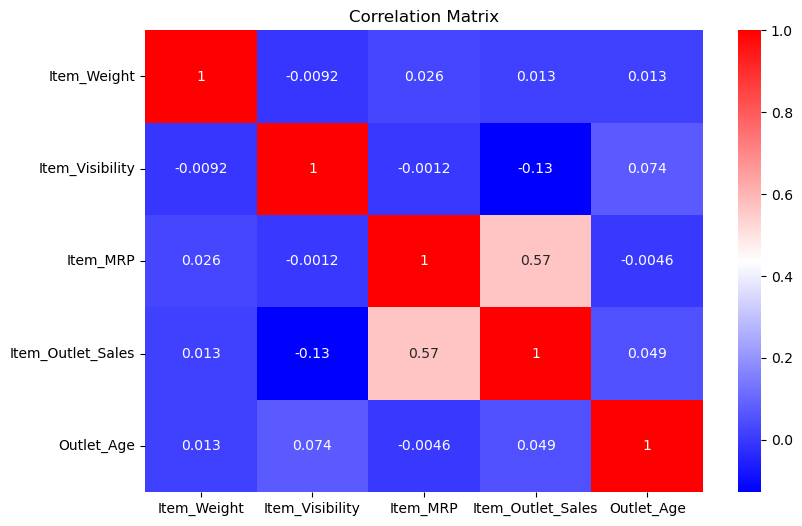

In [40]:
correlations = final_df.corr(method='pearson')
plt.figure(figsize=(9, 6))
sns.heatmap(correlations, cmap="bwr", annot=True)
plt.title("Correlation Matrix")
plt.show()

# $Data$ $Pre$-$Processing$

In [41]:
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

In [42]:
encoder_fat_content = OrdinalEncoder()
final_df[['Fat_Content']] = encoder_fat_content.fit_transform(final_df[['Item_Fat_Content']])

encoder_outlet_size = OrdinalEncoder(categories = [['Small', 'Medium', 'High']])
final_df[['Outlet_size']] = encoder_outlet_size.fit_transform(final_df[['Outlet_Size']])

encoder_location_type = OrdinalEncoder(categories = [['Tier 1', 'Tier 2', 'Tier 3']])
final_df[['Outlet_Location_Tier']] = encoder_location_type.fit_transform(final_df[['Outlet_Location_Type']])

encoder_outlet_type = OrdinalEncoder(categories = [['Grocery Store', 'Supermarket Type1', 'Supermarket Type2', 'Supermarket Type3']])
final_df[['Outlet_Market_Type']] = encoder_outlet_type.fit_transform(final_df[['Outlet_Type']])

In [43]:
encoder_item_type = LabelEncoder()
df['Item_type']= encoder_item_type.fit_transform(df['Item_Type'])
#df['Item_type'].unique()

In [44]:
final_df.drop(['Item_Fat_Content', 'Outlet_Size',
               'Outlet_Location_Type', 'Outlet_Type',
               'Item_Type'], axis = 1, inplace = True)

In [45]:
final_df.columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales',
       'Outlet_Age', 'Fat_Content', 'Outlet_size', 'Outlet_Location_Tier',
       'Outlet_Market_Type'],
      dtype='object')

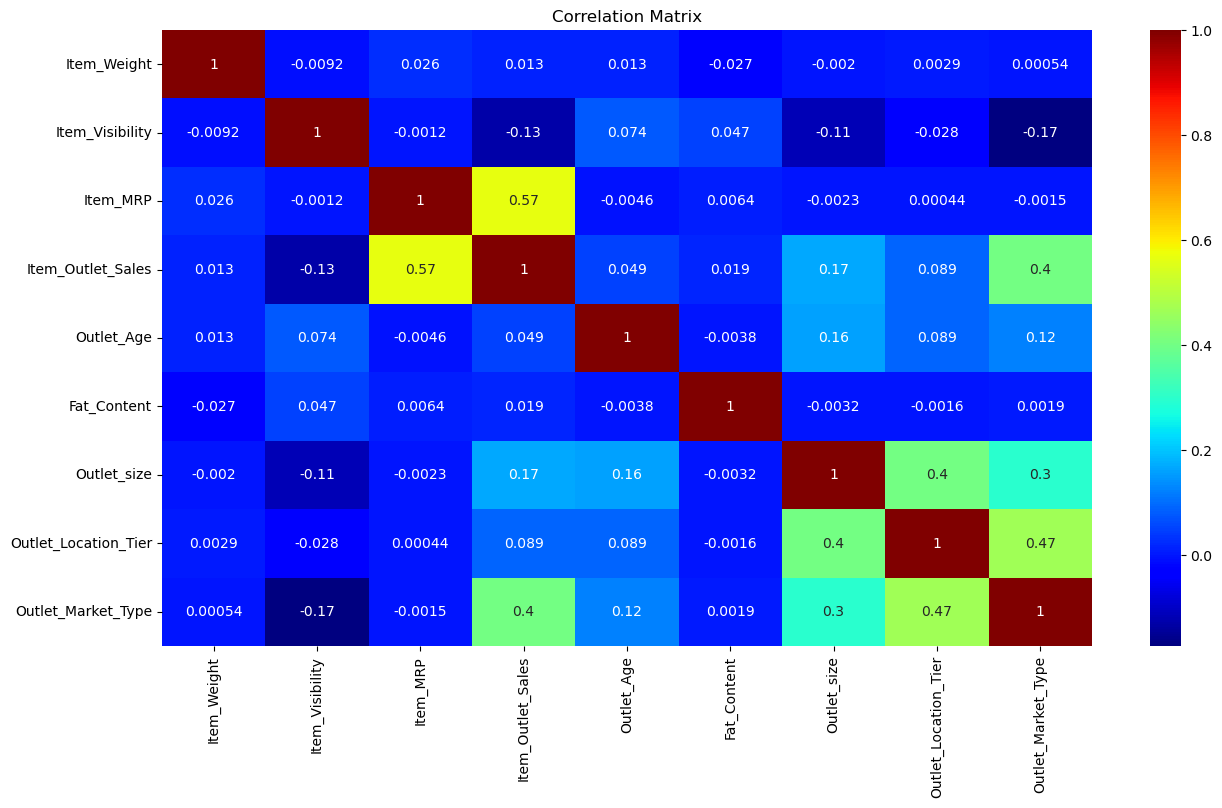

In [46]:
correlations = final_df.corr(method='pearson')
plt.figure(figsize=(15, 8))
sns.heatmap(correlations, cmap="jet", annot=True)
plt.title("Correlation Matrix")
plt.show()

# $Chosing$ $Optimal$ $Features$

In [47]:
#Best selection method based on RSS
#some helper function 
def fit_linear_reg(X,y):
    #fit linear regression model and return RSS and r squared
    model_k = LinearRegression()
    model_k.fit(X,y)
    RSS = mean_squared_error(y,model_k.predict(X))*len(y) 
    R_squared = model_k.score(X,y) 
    adj_R_squared = 1 - (1-R_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    return RSS, R_squared, adj_R_squared 

In [48]:
#Initialize variables 
y = final_df.Item_Outlet_Sales
X = final_df.drop(columns='Item_Outlet_Sales',axis=1) 

m = 8

RSS_list, R_squared_list, feature_list = [], [], []
adj_R_squared_list = []
numb_features = []

#looping over m=1 to m=11 features in X
#Looping over k = 1 to k = 11 features in X
for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):

    #Looping over all possible combinations: from 12 choose k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_linear_reg(X[list(combo)],y)   #Store temp result 
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        adj_R_squared_list.append(tmp_result[2])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,
                   'RSS': RSS_list,
                   'R_squared':R_squared_list,
                   'Adj_R_squared': adj_R_squared_list,
                   'features':feature_list})

C:\Users\balun\AppData\Local\Temp\ipykernel_13348\685183847.py:13: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):


Loop...:   0%|          | 0/8 [00:00<?, ?it/s]

In [49]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]
df_max_adj = df[df.groupby('numb_features')['Adj_R_squared'].transform(max) == df['Adj_R_squared']]
display(df_min.head())
display(df_max_adj.head(10))

,numb_features,RSS,R_squared,Adj_R_squared,features
2,1,1.680850e+10,0.322400,0.322321,"(Item_MRP,)"
25,2,1.279559e+10,0.484173,0.484052,"(Item_MRP, Outlet_Market_Type)"
81,3,1.248490e+10,0.496697,0.496520,"(Item_MRP, Outlet_Location_Tier, Outlet_Market..."
156,4,1.227153e+10,0.505299,0.505066,"(Item_MRP, Outlet_size, Outlet_Location_Tier, ..."
206,5,1.222393e+10,0.507218,0.506928,"(Item_Visibility, Item_MRP, Outlet_size, Outle..."


,numb_features,RSS,R_squared,Adj_R_squared,features
2,1,1.680850e+10,0.322400,0.322321,"(Item_MRP,)"
25,2,1.279559e+10,0.484173,0.484052,"(Item_MRP, Outlet_Market_Type)"
81,3,1.248490e+10,0.496697,0.496520,"(Item_MRP, Outlet_Location_Tier, Outlet_Market..."
156,4,1.227153e+10,0.505299,0.505066,"(Item_MRP, Outlet_size, Outlet_Location_Tier, ..."
206,5,1.222393e+10,0.507218,0.506928,"(Item_Visibility, Item_MRP, Outlet_size, Outle..."
243,6,1.221702e+10,0.507497,0.507149,"(Item_Visibility, Item_MRP, Fat_Content, Outle..."
250,7,1.221698e+10,0.507498,0.507093,"(Item_Weight, Item_Visibility, Item_MRP, Fat_C..."
254,8,1.221698e+10,0.507498,0.507035,"(Item_Weight, Item_Visibility, Item_MRP, Outle..."


In [50]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df.head()

,numb_features,RSS,R_squared,Adj_R_squared,features,min_RSS,max_R_squared
0,1,2.480165e+10,0.000173,0.000056,"(Item_Weight,)",1.680850e+10,0.3224
1,1,2.439764e+10,0.016460,0.016345,"(Item_Visibility,)",1.680850e+10,0.3224
2,1,1.680850e+10,0.322400,0.322321,"(Item_MRP,)",1.680850e+10,0.3224
3,1,2.474619e+10,0.002409,0.002292,"(Outlet_Age,)",1.680850e+10,0.3224
4,1,2.479702e+10,0.000360,0.000243,"(Fat_Content,)",1.680850e+10,0.3224


In [51]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df['max_Adj_R_squared'] = df.groupby('numb_features')['Adj_R_squared'].transform(max)
df.head()

,numb_features,RSS,R_squared,Adj_R_squared,features,min_RSS,max_R_squared,max_Adj_R_squared
0,1,2.480165e+10,0.000173,0.000056,"(Item_Weight,)",1.680850e+10,0.3224,0.322321
1,1,2.439764e+10,0.016460,0.016345,"(Item_Visibility,)",1.680850e+10,0.3224,0.322321
2,1,1.680850e+10,0.322400,0.322321,"(Item_MRP,)",1.680850e+10,0.3224,0.322321
3,1,2.474619e+10,0.002409,0.002292,"(Outlet_Age,)",1.680850e+10,0.3224,0.322321
4,1,2.479702e+10,0.000360,0.000243,"(Fat_Content,)",1.680850e+10,0.3224,0.322321


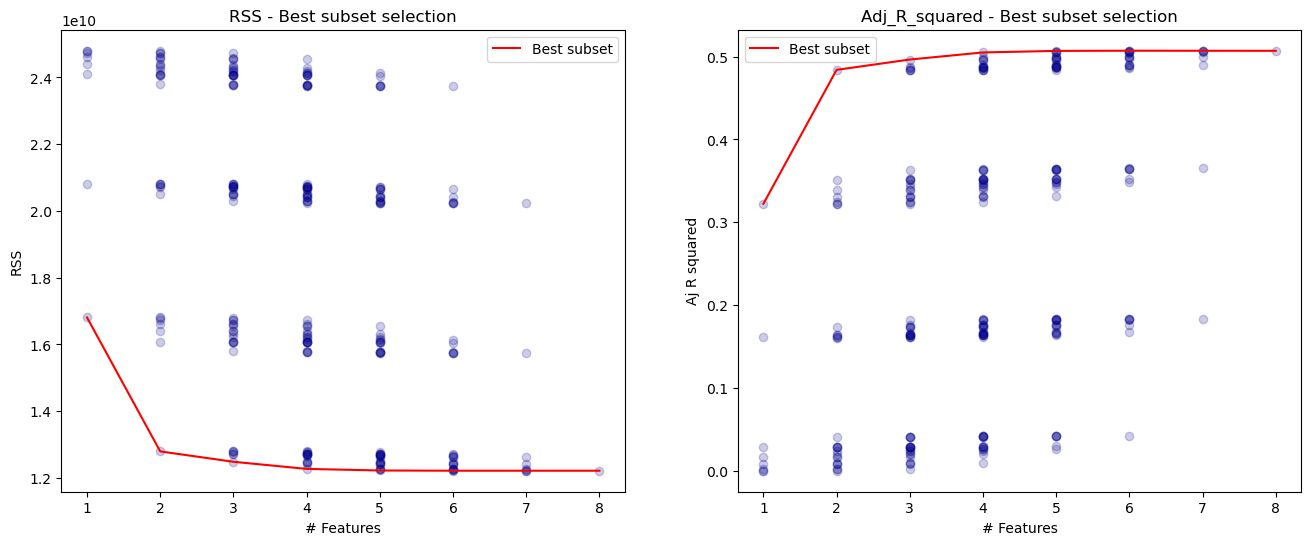

In [52]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.Adj_R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_Adj_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('Aj R squared')
ax.set_title('Adj_R_squared - Best subset selection')
ax.legend()

plt.show()

# $Modeling$

In [53]:
X = final_df.drop('Item_Outlet_Sales', axis = 1)
y = final_df.Item_Outlet_Sales

X = num_pipeline.fit_transform(X) 

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1)

### $Linear$ $Regression$

In [54]:
model = LinearRegression() 
model.fit(X_train,y_train)

LinearRegression()

In [55]:
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

0.5133842184767623
0.4853479697046762


### $Random$ $Forest$ $Regressor$

In [56]:
RFR = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 18).fit(X_train, y_train)

In [57]:
prediction = RFR.predict(X_test)

print(RFR.score(X_train, y_train))
print(RFR.score(X_test, y_test))

0.5541825663609047
0.5177051251813428


### $Lasso$ $Regression$

In [58]:
model = Lasso()
model.fit(X_train, y_train)

Lasso()

In [59]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.5133805670047218
0.4853460155650199


### $XG$ $Boost$

In [60]:
model = XGBRegressor(n_estimators = 750,learning_rate = 0.007)

In [61]:
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.007, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=750, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [62]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.686947133103951
0.5903605454579854


### $Gradient$ $Boosting$ $Regressor$

In [63]:
gbr = GradientBoostingRegressor()

In [64]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor()

In [65]:
print(gbr.score(X_train, y_train))
print(gbr.score(X_test, y_test))

0.6382546894074297
0.5937332269742217


### $Bagging$ $Regressor$

In [66]:
model = GradientBoostingRegressor()

In [67]:
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [68]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6382546894074297
0.5938519979332226


### $Support$ $Vector$ $Regressor$

In [69]:
svr = SVR(gamma='auto', kernel='poly', C=15)

In [70]:
svr.fit(X_train, y_train)

SVR(C=15, gamma='auto', kernel='poly')

In [71]:
print(svr.score(X_train, y_train))
print(svr.score(X_test, y_test))

0.4891410821691302
0.45758511061581975


### $Decision$ $Tree$ $Regressor$

In [72]:
dtr = DecisionTreeRegressor()

In [73]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor()

In [74]:
print(dtr.score(X_train, y_train))
print(dtr.score(X_test, y_test))

1.0
0.21116929993203581


# $Final$ $Results$

#### $Linear$ $Regression$ : `Train : 51%`  `Test : 48%`
#### $RandomForest$ $Regressor$ : `Train : 55%`  `Test : 52%`
#### $Lasso$ $Regresion$ : `Train : 51%`  `Test : 49%`
#### $XG$ $Boost$ $Regressor$ : `Train : 69%`  `Test : 59%`
#### $Gradient$ $Boosting$ $Regressor$ : `Train : 64%`  `Test : 59%`
#### $Bagging$ $Regressor$ : `Train : 64%`  `Test : 59%`
#### $Support$ $Vector$ $Regressor$ : `Train : 49%`  `Test : 46%`
#### $DecisionTree$ $Regressor$ : `Train : 100%`  `Test : 21%`





## `XG Boost Regressor` is currently the best model.